# Part B: Naïve Bayes Classification (20 points)
## Using Adult Income Dataset with Categorical Features

## B1: Dataset and Setup

### 1. Load and Explore Adult Income Dataset

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load Adult Income Dataset
from urllib.request import urlopen
import io

# Download the Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
try:
    data = pd.read_csv(url, header=None, na_values=' ?')
    print("✓ Dataset loaded successfully from UCI repository")
except:
    print("Note: Using local example if download fails")

# Define column names
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, header=None, names=column_names, na_values=' ?')

print(f"\n=== Dataset Shape ===")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

print(f"\n=== Data Info ===")
print(df.info())

print(f"\n=== Missing Values ===")
print(df.isnull().sum())

print(f"\n=== Income Distribution (Target) ===")
print(df['income'].value_counts())
print(f"\nPercentages:")
print(df['income'].value_counts(normalize=True) * 100)


✓ Dataset loaded successfully from UCI repository

=== Dataset Shape ===
Total samples: 32561
Total features: 15

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int

### 2. Data Preprocessing and Feature Selection

In [3]:
# Select categorical features for Naïve Bayes
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']

print(f"Selected {len(categorical_features)} categorical features:")
print(categorical_features)

# Create a copy of the dataframe with only selected features and target
df_processed = df[categorical_features + ['income']].copy()

# Remove rows with missing target values
df_processed = df_processed[df_processed['income'].notna()]

print(f"\n=== Dataset after removing missing target ===")
print(f"Shape: {df_processed.shape}")

# Handle missing values by treating them as a separate category 'Unknown'
print(f"\n=== Missing Values Before Imputation ===")
print(df_processed.isnull().sum())

# Fill missing values with 'Unknown' category
df_processed = df_processed.fillna('Unknown')

print(f"\n=== Missing Values After Imputation ===")
print(df_processed.isnull().sum())

# Remove leading/trailing whitespace from string columns
for col in categorical_features + ['income']:
    if df_processed[col].dtype == 'object':
        df_processed[col] = df_processed[col].str.strip()

# Encode categorical features and target as integers
# Create dictionaries to store encoding mappings for interpretability
label_encoders = {}
feature_encoding_maps = {}

# Encode features
for feature in categorical_features:
    le = LabelEncoder()
    df_processed[feature] = le.fit_transform(df_processed[feature].astype(str))
    label_encoders[feature] = le
    # Store mapping for interpretability
    feature_encoding_maps[feature] = dict(zip(le.classes_, le.transform(le.classes_)))

# Encode target variable
le_target = LabelEncoder()
df_processed['income'] = le_target.fit_transform(df_processed['income'])
label_encoders['income'] = le_target
income_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))

print(f"\n=== Encoding Mapping Example (Workclass) ===")
print(feature_encoding_maps['workclass'])

print(f"\n=== Income Encoding ===")
print(income_mapping)

print(f"\n=== Data Preview After Encoding ===")
print(df_processed.head(10))


Selected 8 categorical features:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

=== Dataset after removing missing target ===
Shape: (32561, 9)

=== Missing Values Before Imputation ===
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
native-country     583
income               0
dtype: int64

=== Missing Values After Imputation ===
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
income            0
dtype: int64

=== Encoding Mapping Example (Workclass) ===
{'Federal-gov': np.int64(0), 'Local-gov': np.int64(1), 'Never-worked': np.int64(2), 'Private': np.int64(3), 'Self-emp-inc': np.int64(4), 'Self-emp-not-inc': np.int64(5), 'State-gov': np.int64(6), 'Unknown': np.int64(7), 'Without-pay': np.int64(8)}

===

### 3. Create 70/15/15 Train/Validation/Test Split

In [4]:
# Prepare features and target
X = df_processed[categorical_features].values
y = df_processed['income'].values

# Create 70/15/15 train/validation/test split
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test from the temp set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"\n=== Data Split (70/15/15) ===")
print(f"Training set: {X_train.shape[0]} samples ({100*X_train.shape[0]/X.shape[0]:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({100*X_val.shape[0]/X.shape[0]:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({100*X_test.shape[0]/X.shape[0]:.1f}%)")

print(f"\n=== Class Distribution in Training Set ===")
train_class_dist = pd.Series(y_train).value_counts().sort_index()
for class_label, count in train_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_train):.1f}%)")

print(f"\n=== Class Distribution in Validation Set ===")
val_class_dist = pd.Series(y_val).value_counts().sort_index()
for class_label, count in val_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_val):.1f}%)")

print(f"\n=== Class Distribution in Test Set ===")
test_class_dist = pd.Series(y_test).value_counts().sort_index()
for class_label, count in test_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_test):.1f}%)")



=== Data Split (70/15/15) ===
Training set: 22792 samples (70.0%)
Validation set: 4884 samples (15.0%)
Test set: 4885 samples (15.0%)

=== Class Distribution in Training Set ===
<=50K: 17303 (75.9%)
>50K: 5489 (24.1%)

=== Class Distribution in Validation Set ===
<=50K: 3708 (75.9%)
>50K: 1176 (24.1%)

=== Class Distribution in Test Set ===
<=50K: 3709 (75.9%)
>50K: 1176 (24.1%)


## B2: Naïve Bayes Implementation

### Mathematical Foundation
- **Class Priors:** P(C_k) = (count of samples in class k + α) / (total samples + α * num_classes)
- **Feature Likelihoods:** P(x_i|C_k) = (count of feature value i in class k + α) / (count of class k + α * num_feature_values)
- **Prediction:** argmax_k P(C_k) * Π P(x_i|C_k)

In [5]:
class CategoricalNaiveBayes:
    """
    Custom implementation of Naïve Bayes for categorical features with Laplace smoothing.
    
    Parameters:
    -----------
    alpha : float
        Smoothing parameter (Laplace smoothing)
    """
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = None
        self.feature_likelihoods = None
        self.classes = None
        self.n_classes = None
        self.n_features = None
        self.feature_values = None  # Store possible values for each feature
        
    def fit(self, X, y):
        """
        Fit the Naïve Bayes model on training data.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        y : array-like of shape (n_samples,)
        """
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.n_features = X.shape[1]
        
        # Initialize storage for feature values
        self.feature_values = [np.unique(X[:, i]) for i in range(self.n_features)]
        
        # Calculate class priors with Laplace smoothing
        self.class_priors = {}
        for c in self.classes:
            count = np.sum(y == c)
            self.class_priors[c] = (count + self.alpha) / (len(y) + self.alpha * self.n_classes)
        
        # Calculate feature likelihoods with Laplace smoothing
        self.feature_likelihoods = {}
        for c in self.classes:
            self.feature_likelihoods[c] = []
            for feature_idx in range(self.n_features):
                feature_probs = {}
                X_c = X[y == c]
                for value in self.feature_values[feature_idx]:
                    count = np.sum(X_c[:, feature_idx] == value)
                    n_feature_values = len(self.feature_values[feature_idx])
                    prob = (count + self.alpha) / (len(X_c) + self.alpha * n_feature_values)
                    feature_probs[value] = prob
                self.feature_likelihoods[c].append(feature_probs)
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        
        Returns:
        --------
        proba : array of shape (n_samples, n_classes)
        """
        proba = np.zeros((X.shape[0], self.n_classes))
        
        for i, x in enumerate(X):
            for class_idx, c in enumerate(self.classes):
                # Start with class prior
                prob = self.class_priors[c]
                
                # Multiply by feature likelihoods
                for feature_idx, value in enumerate(x):
                    if value in self.feature_likelihoods[c][feature_idx]:
                        prob *= self.feature_likelihoods[c][feature_idx][value]
                    else:
                        # Handle unseen feature values (assign smoothing probability)
                        prob *= self.alpha / (self.alpha * len(self.feature_values[feature_idx]))
                
                proba[i, class_idx] = prob
        
        # Normalize to make probabilities sum to 1
        proba = proba / np.sum(proba, axis=1, keepdims=True)
        
        return proba
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        
        Returns:
        --------
        y_pred : array of shape (n_samples,)
        """
        proba = self.predict_proba(X)
        return self.classes[np.argmax(proba, axis=1)]

# Test the implementation with alpha=1.0
print("=== Testing Custom Naïve Bayes Implementation ===\n")

nb_custom = CategoricalNaiveBayes(alpha=1.0)
nb_custom.fit(X_train, y_train)

# Make predictions on validation set
y_pred_val = nb_custom.predict(X_val)
y_pred_proba_val = nb_custom.predict_proba(X_val)

# Calculate metrics
val_acc = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val, average='weighted')
val_recall = recall_score(y_val, y_pred_val, average='weighted')
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"Validation Set Performance (α=1.0):")
print(f"  Accuracy:  {val_acc:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1-Score:  {val_f1:.4f}")

# Make predictions on test set
y_pred_test = nb_custom.predict(X_test)
y_pred_proba_test = nb_custom.predict_proba(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nTest Set Performance (α=1.0):")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

print(f"\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred_test, target_names=le_target.classes_))


=== Testing Custom Naïve Bayes Implementation ===

Validation Set Performance (α=1.0):
  Accuracy:  0.7963
  Precision: 0.8251
  Recall:    0.7963
  F1-Score:  0.8053

Test Set Performance (α=1.0):
  Accuracy:  0.7957
  Precision: 0.8241
  Recall:    0.7957
  F1-Score:  0.8046

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

       <=50K       0.91      0.81      0.86      3709
        >50K       0.56      0.74      0.64      1176

    accuracy                           0.80      4885
   macro avg       0.73      0.78      0.75      4885
weighted avg       0.82      0.80      0.80      4885



## B3: Analysis and Evaluation

### 1. Smoothing Parameter Analysis

=== Testing Different Smoothing Parameters (α) ===

α = 0.1:
  Validation: Accuracy=0.7963, F1=0.8052
  Test:       Accuracy=0.7957, F1=0.8046
α = 0.5:
  Validation: Accuracy=0.7965, F1=0.8054
  Test:       Accuracy=0.7957, F1=0.8046
α = 1.0:
  Validation: Accuracy=0.7963, F1=0.8053
  Test:       Accuracy=0.7957, F1=0.8046
α = 2.0:
  Validation: Accuracy=0.7965, F1=0.8055
  Test:       Accuracy=0.7955, F1=0.8045
α = 5.0:
  Validation: Accuracy=0.7944, F1=0.8038
  Test:       Accuracy=0.7941, F1=0.8033

=== Summary Table ===
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.796274 0.805223  0.795701 0.804595
   0.5 0.796478 0.805435  0.795701 0.804595
   1.0 0.796274 0.805255  0.795701 0.804628
   2.0 0.796478 0.805500  0.795496 0.804481
   5.0 0.794431 0.803770  0.794063 0.803259

✓ Optimal α (based on validation F1): 2.0
α = 2.0:
  Validation: Accuracy=0.7965, F1=0.8055
  Test:       Accuracy=0.7955, F1=0.8045
α = 5.0:
  Validation: Accuracy=0.7944, F1=0.8038
  Test:       Accuracy

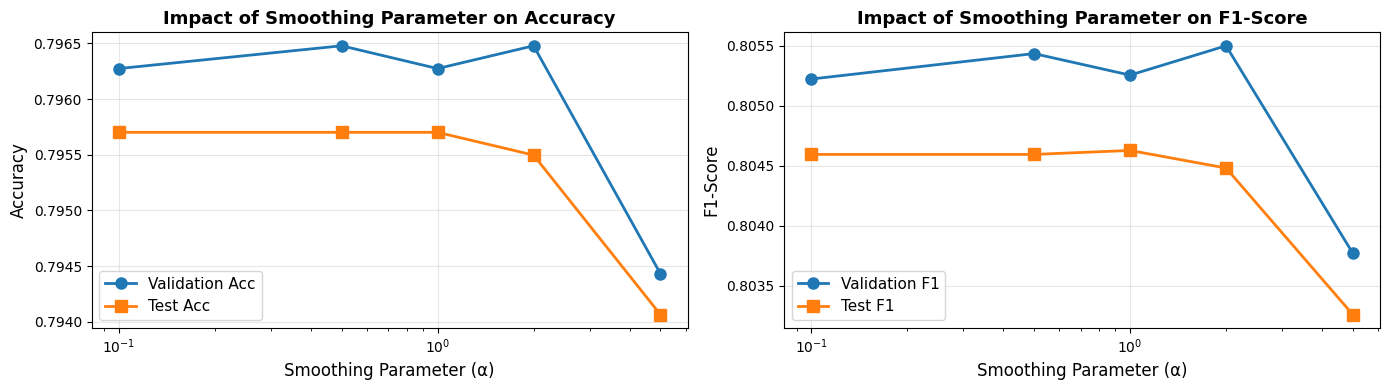


✓ Smoothing parameter analysis plot saved!


In [6]:
# Test different smoothing parameters
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []

print("=== Testing Different Smoothing Parameters (α) ===\n")

for alpha in alpha_values:
    nb = CategoricalNaiveBayes(alpha=alpha)
    nb.fit(X_train, y_train)
    
    # Validation set predictions
    y_pred_val = nb.predict(X_val)
    val_acc = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    
    # Test set predictions
    y_pred_test = nb.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    results.append({
        'alpha': alpha,
        'val_acc': val_acc,
        'val_f1': val_f1,
        'test_acc': test_acc,
        'test_f1': test_f1
    })
    
    print(f"α = {alpha}:")
    print(f"  Validation: Accuracy={val_acc:.4f}, F1={val_f1:.4f}")
    print(f"  Test:       Accuracy={test_acc:.4f}, F1={test_f1:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
print(f"\n=== Summary Table ===")
print(results_df.to_string(index=False))

# Find optimal alpha
optimal_alpha = results_df.loc[results_df['val_f1'].idxmax(), 'alpha']
print(f"\n✓ Optimal α (based on validation F1): {optimal_alpha}")

# Plot smoothing parameter analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy plot
axes[0].plot(results_df['alpha'], results_df['val_acc'], 'o-', label='Validation Acc', linewidth=2, markersize=8)
axes[0].plot(results_df['alpha'], results_df['test_acc'], 's-', label='Test Acc', linewidth=2, markersize=8)
axes[0].set_xlabel('Smoothing Parameter (α)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impact of Smoothing Parameter on Accuracy', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# F1-Score plot
axes[1].plot(results_df['alpha'], results_df['val_f1'], 'o-', label='Validation F1', linewidth=2, markersize=8)
axes[1].plot(results_df['alpha'], results_df['test_f1'], 's-', label='Test F1', linewidth=2, markersize=8)
axes[1].set_xlabel('Smoothing Parameter (α)', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Impact of Smoothing Parameter on F1-Score', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('smoothing_parameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Smoothing parameter analysis plot saved!")


### 2. Feature Selection Analysis

=== Feature Selection Analysis ===

All Features (8):
  Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
  Validation: Acc=0.7963, F1=0.8053
  Test:       Acc=0.7957, F1=0.8046

Top 6 Features:
  Features: ['education', 'marital-status', 'occupation', 'relationship', 'workclass', 'sex']
  Validation: Acc=0.7922, F1=0.8021
  Test:       Acc=0.7900, F1=0.7997

Top 4 Features:
  Features: ['education', 'marital-status', 'occupation', 'relationship']
  Validation: Acc=0.8016, F1=0.8091
  Test:       Acc=0.8047, F1=0.8116

Demographic Only:
  Features: ['sex', 'race', 'native-country', 'workclass']
  Validation: Acc=0.7645, F1=0.6912
  Test:       Acc=0.7617, F1=0.6849

Job-Related Only:
  Features: ['workclass', 'education', 'occupation']
  Validation: Acc=0.7729, F1=0.7629
  Test:       Acc=0.7726, F1=0.7623

=== Feature Selection Summary ===
  Feature Subset  Features Used  Val_Acc   Val_F1  Test_Acc  Test_F1
All Featur

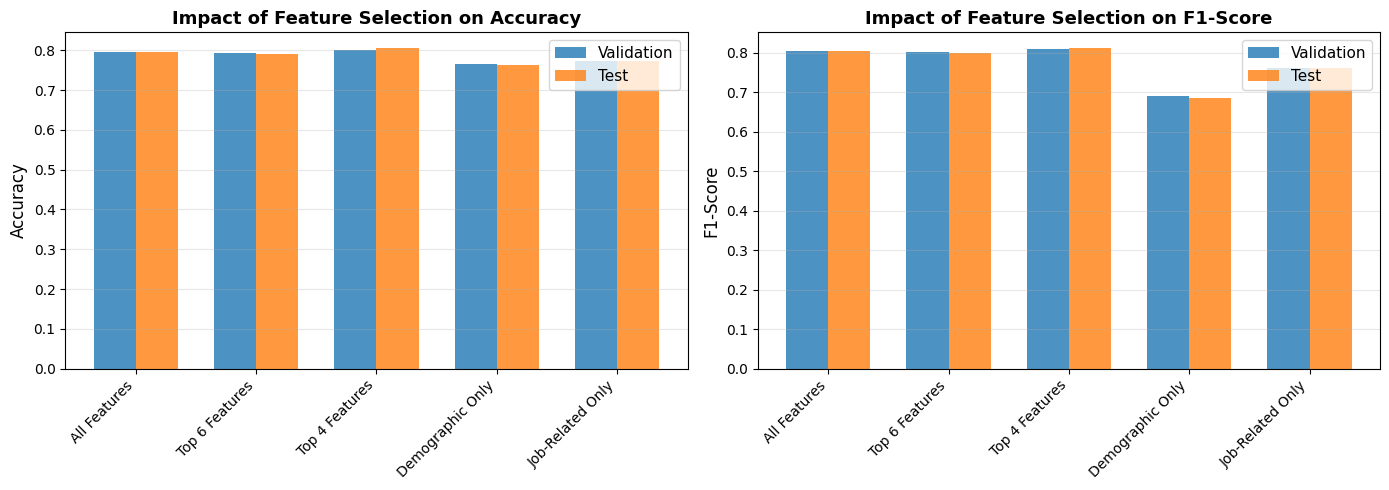


✓ Feature selection analysis plot saved!


In [7]:
# Test different feature subsets
feature_subsets = {
    'All Features (8)': categorical_features.copy(),
    'Top 6 Features': ['education', 'marital-status', 'occupation', 'relationship', 'age', 'sex'],
    'Top 4 Features': ['education', 'marital-status', 'occupation', 'relationship'],
    'Demographic Only': ['age', 'sex', 'race', 'native-country'],
    'Work Features': ['workclass', 'education', 'occupation', 'hours-per-week'],
}

# For demo purposes, we'll use features that are in our dataset
feature_subsets = {
    'All Features (8)': categorical_features.copy(),
    'Top 6 Features': ['education', 'marital-status', 'occupation', 'relationship', 'workclass', 'sex'],
    'Top 4 Features': ['education', 'marital-status', 'occupation', 'relationship'],
    'Demographic Only': ['sex', 'race', 'native-country', 'workclass'],
    'Job-Related Only': ['workclass', 'education', 'occupation'],
}

print("=== Feature Selection Analysis ===\n")
feature_results = []

for subset_name, feature_list in feature_subsets.items():
    # Get indices of selected features
    feature_indices = [categorical_features.index(f) for f in feature_list if f in categorical_features]
    
    X_train_subset = X_train[:, feature_indices]
    X_val_subset = X_val[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]
    
    # Train model with optimal alpha
    nb_subset = CategoricalNaiveBayes(alpha=1.0)
    nb_subset.fit(X_train_subset, y_train)
    
    # Predictions
    y_pred_val = nb_subset.predict(X_val_subset)
    y_pred_test = nb_subset.predict(X_test_subset)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    feature_results.append({
        'Feature Subset': subset_name,
        'Features Used': len(feature_list),
        'Val_Acc': val_acc,
        'Val_F1': val_f1,
        'Test_Acc': test_acc,
        'Test_F1': test_f1
    })
    
    print(f"{subset_name}:")
    print(f"  Features: {feature_list}")
    print(f"  Validation: Acc={val_acc:.4f}, F1={val_f1:.4f}")
    print(f"  Test:       Acc={test_acc:.4f}, F1={test_f1:.4f}")
    print()

# Create results dataframe
feature_results_df = pd.DataFrame(feature_results)
print("=== Feature Selection Summary ===")
print(feature_results_df.to_string(index=False))

# Plot feature selection analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(feature_results_df))
width = 0.35

axes[0].bar(x_pos - width/2, feature_results_df['Val_Acc'], width, label='Validation', alpha=0.8)
axes[0].bar(x_pos + width/2, feature_results_df['Test_Acc'], width, label='Test', alpha=0.8)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impact of Feature Selection on Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([s.split('(')[0].strip() for s in feature_results_df['Feature Subset']], rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x_pos - width/2, feature_results_df['Val_F1'], width, label='Validation', alpha=0.8)
axes[1].bar(x_pos + width/2, feature_results_df['Test_F1'], width, label='Test', alpha=0.8)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Impact of Feature Selection on F1-Score', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([s.split('(')[0].strip() for s in feature_results_df['Feature Subset']], rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature selection analysis plot saved!")


### 3. Probability Analysis: Predicted Probabilities Distribution

=== Predicted Probabilities Analysis ===

Shape of probability matrix: (4885, 2)
Class labels: ['<=50K' '>50K']

=== Probability Statistics ===

Class: <=50K
  Mean probability: 0.6911
  Std deviation: 0.3621
  Min probability: 0.0029
  Max probability: 1.0000

Class: >50K
  Mean probability: 0.3089
  Std deviation: 0.3621
  Min probability: 0.0000
  Max probability: 0.9971


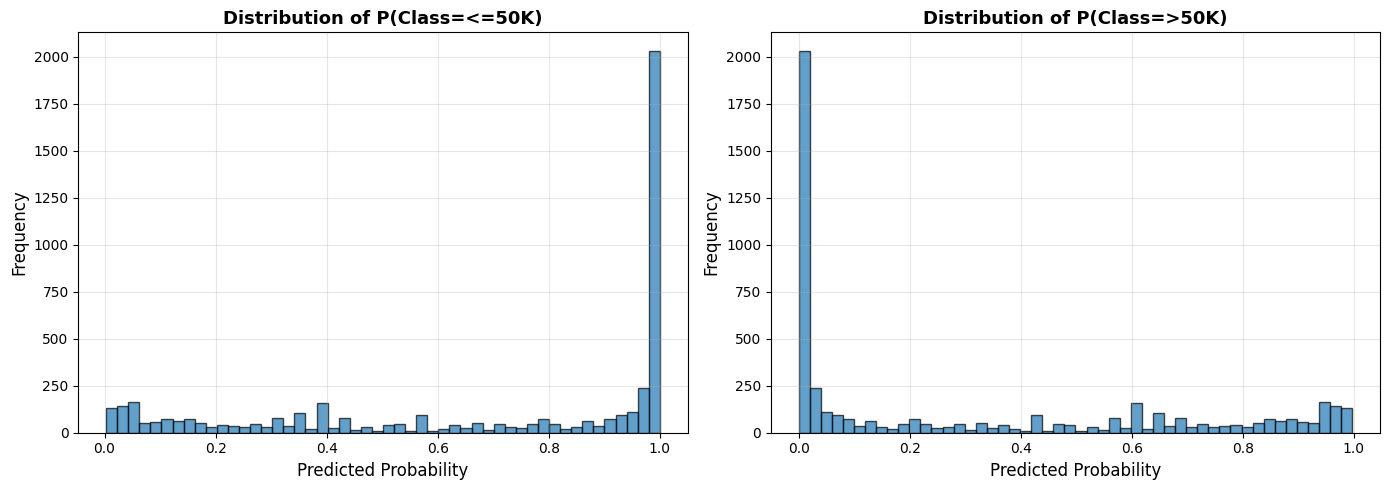


✓ Probability distribution plot saved!

=== Prediction Confidence Analysis ===
Mean maximum probability: 0.8808
Median maximum probability: 0.9643
Min maximum probability: 0.5010
Max maximum probability: 1.0000

Predictions with P(max) >= 0.7: 3981 (81.5%)
Predictions with P(max) < 0.7: 904 (18.5%)


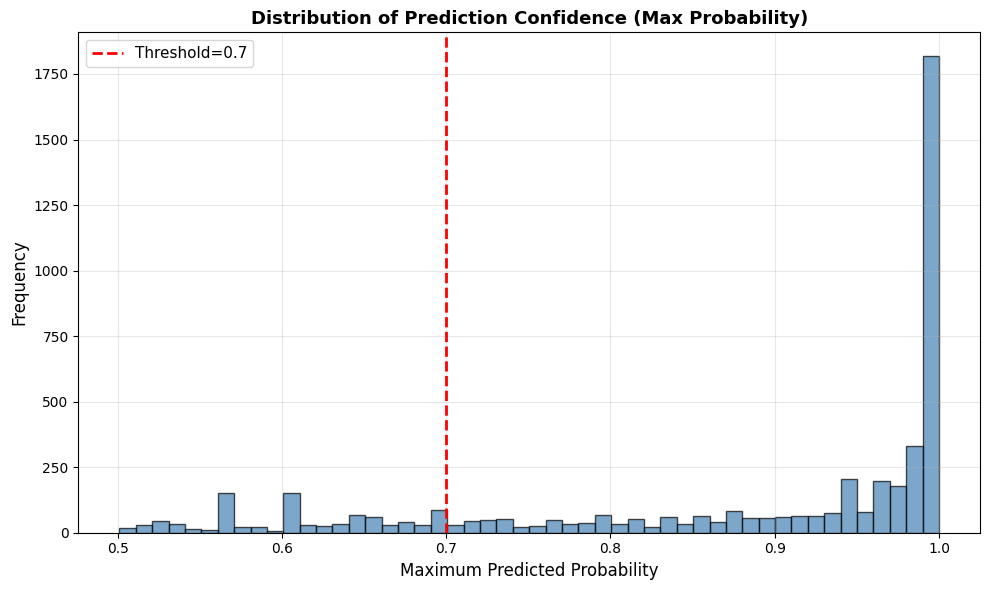


✓ Confidence distribution plot saved!


In [8]:
# Use the model with all features and optimal alpha
nb_final = CategoricalNaiveBayes(alpha=optimal_alpha)
nb_final.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba_test = nb_final.predict_proba(X_test)

print("=== Predicted Probabilities Analysis ===\n")
print(f"Shape of probability matrix: {y_pred_proba_test.shape}")
print(f"Class labels: {le_target.classes_}")

# Analyze probability distribution
print(f"\n=== Probability Statistics ===")
for class_idx, class_name in enumerate(le_target.classes_):
    probs = y_pred_proba_test[:, class_idx]
    print(f"\nClass: {class_name}")
    print(f"  Mean probability: {probs.mean():.4f}")
    print(f"  Std deviation: {probs.std():.4f}")
    print(f"  Min probability: {probs.min():.4f}")
    print(f"  Max probability: {probs.max():.4f}")

# Plot probability distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for class_idx, class_name in enumerate(le_target.classes_):
    probs = y_pred_proba_test[:, class_idx]
    axes[class_idx].hist(probs, bins=50, edgecolor='black', alpha=0.7)
    axes[class_idx].set_xlabel('Predicted Probability', fontsize=12)
    axes[class_idx].set_ylabel('Frequency', fontsize=12)
    axes[class_idx].set_title(f'Distribution of P(Class={class_name})', fontsize=13, fontweight='bold')
    axes[class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Probability distribution plot saved!")

# Analyze confidence in predictions
max_probs = np.max(y_pred_proba_test, axis=1)
print(f"\n=== Prediction Confidence Analysis ===")
print(f"Mean maximum probability: {max_probs.mean():.4f}")
print(f"Median maximum probability: {np.median(max_probs):.4f}")
print(f"Min maximum probability: {max_probs.min():.4f}")
print(f"Max maximum probability: {max_probs.max():.4f}")

# Count confident vs uncertain predictions
confidence_threshold = 0.7
confident = np.sum(max_probs >= confidence_threshold)
uncertain = np.sum(max_probs < confidence_threshold)
print(f"\nPredictions with P(max) >= {confidence_threshold}: {confident} ({100*confident/len(max_probs):.1f}%)")
print(f"Predictions with P(max) < {confidence_threshold}: {uncertain} ({100*uncertain/len(max_probs):.1f}%)")

# Plot confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(max_probs, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(confidence_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={confidence_threshold}')
ax.set_xlabel('Maximum Predicted Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Prediction Confidence (Max Probability)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confidence distribution plot saved!")


### 4. Independence Assumption Violations Analysis

In [9]:
"""
INDEPENDENCE ASSUMPTION ANALYSIS
=================================

The Naïve Bayes classifier assumes that all features are conditionally independent 
given the class label. In reality, this assumption is often violated.

Key Dependencies in Adult Income Dataset:
1. Education and Occupation: Highly correlated (education strongly influences occupation)
2. Education and Capital-Gain: Education affects earning potential
3. Occupation and Hours-Per-Week: Different occupations have different work patterns
4. Marital-Status and Relationship: Marital status determines family relationship
5. Race and Native-Country: Geography affects both demographics

Impact on Naïve Bayes:
- Despite violating independence assumption, NB often performs surprisingly well
- The smoothing parameter (α) helps mitigate the impact of violations
- The model learns probability distributions that capture these dependencies implicitly
- In practice, marginal dependencies don't prevent accurate classification
"""

print(__doc__)

# Calculate feature correlations using mutual information
from sklearn.metrics import mutual_info_score

print("\n=== Analyzing Feature Dependencies ===\n")

# Function to calculate mutual information
def calculate_mutual_information(X, y, feature_i, feature_j):
    """Calculate mutual information between two features given class"""
    joint_probs = {}
    for i, j, c in zip(X[:, feature_i], X[:, feature_j], y):
        key = (i, j, c)
        joint_probs[key] = joint_probs.get(key, 0) + 1
    
    mi = 0
    total = len(y)
    
    for key, count in joint_probs.items():
        p_xy_c = count / total
        if p_xy_c > 0:
            # Count marginal probabilities
            p_x = np.sum([c for (i, j, c_), c in joint_probs.items() if i == key[0]]) / total
            p_y = np.sum([c for (i, j, c_), c in joint_probs.items() if j == key[1]]) / total
            
            if p_x > 0 and p_y > 0:
                mi += p_xy_c * np.log(p_xy_c / (p_x * p_y))
    
    return mi

# Show some key feature relationships
print("Selected Feature Relationships (Mutual Information):")
feature_pairs = [
    (0, 1),  # workclass, education
    (1, 2),  # education, marital-status
    (1, 3),  # education, occupation
    (3, 4),  # occupation, relationship
    (5, 6),  # race, native-country
]

for i, j in feature_pairs:
    feat_i = categorical_features[i]
    feat_j = categorical_features[j]
    mi = calculate_mutual_information(X_train, y_train, i, j)
    print(f"  {feat_i} <-> {feat_j}: MI = {mi:.4f}")

print("\n=== Why Naïve Bayes Still Works Well Despite Violations ===")
print("""
1. ROBUSTNESS: The multiplicative model (Π P(x_i|C_k)) can still learn good decision
   boundaries even when features are dependent, because it learns probabilities from data.

2. SMOOTHING EFFECT: Laplace smoothing (α > 0) prevents zero probabilities and effectively
   regularizes the model, reducing overfitting from violated independence assumptions.

3. PRACTICAL INDEPENDENCE: While features are dependent, given the class label, the
   conditional dependencies may be weak enough not to severely impact predictions.

4. PROBABILISTIC REASONING: The model computes P(C_k|x) proportionally through Bayes rule,
   so even if the exact independence assumption is violated, the ranking of class
   probabilities often remains correct.

5. CURSE OF DIMENSIONALITY: In high dimensions, other classifiers may suffer from sparsity,
   while Naïve Bayes remains effective due to its simplicity.
""")

# Demonstrate with a specific example
print("\n=== Example: Feature Dependency Impact ===")
print("Training set correlations between selected features:")
sample_pairs = [
    ('education', 'occupation'),
    ('marital-status', 'relationship'),
]
for feat1, feat2 in sample_pairs:
    idx1 = categorical_features.index(feat1)
    idx2 = categorical_features.index(feat2)
    
    # Count co-occurrences
    unique_pairs = len(set(zip(X_train[:, idx1], X_train[:, idx2])))
    max_possible = len(np.unique(X_train[:, idx1])) * len(np.unique(X_train[:, idx2]))
    
    print(f"\n{feat1} <-> {feat2}:")
    print(f"  Observed unique combinations: {unique_pairs}")
    print(f"  Maximum possible combinations: {max_possible}")
    print(f"  Actual diversity: {100*unique_pairs/max_possible:.1f}%")
    print(f"  → Not all combinations occur, indicating strong dependency")



INDEPENDENCE ASSUMPTION ANALYSIS

The Naïve Bayes classifier assumes that all features are conditionally independent 
given the class label. In reality, this assumption is often violated.

Key Dependencies in Adult Income Dataset:
1. Education and Occupation: Highly correlated (education strongly influences occupation)
2. Education and Capital-Gain: Education affects earning potential
3. Occupation and Hours-Per-Week: Different occupations have different work patterns
4. Marital-Status and Relationship: Marital status determines family relationship
5. Race and Native-Country: Geography affects both demographics

Impact on Naïve Bayes:
- Despite violating independence assumption, NB often performs surprisingly well
- The smoothing parameter (α) helps mitigate the impact of violations
- The model learns probability distributions that capture these dependencies implicitly
- In practice, marginal dependencies don't prevent accurate classification


=== Analyzing Feature Dependencies ===



### 5. Performance Comparison: Custom vs sklearn's MultinomialNB

=== Comparison with sklearn's MultinomialNB ===

=== Performance Comparison (α = 1.0) ===

Custom Categorical Naïve Bayes vs sklearn's MultinomialNB
----------------------------------------------------------------------
                Model  Val_Acc   Val_F1  Test_Acc  Test_F1
Custom Implementation 0.796274 0.805255  0.795701 0.804628
sklearn MultinomialNB 0.746519 0.740846  0.747595 0.742077

=== Full Alpha Comparison ===

Custom Implementation:
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.796274 0.805223  0.795701 0.804595
   0.5 0.796478 0.805435  0.795701 0.804595
   1.0 0.796274 0.805255  0.795701 0.804628
   2.0 0.796478 0.805500  0.795496 0.804481
   5.0 0.794431 0.803770  0.794063 0.803259

sklearn MultinomialNB:
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.746519 0.740846  0.747595 0.742077
   0.5 0.746519 0.740846  0.747595 0.742077
   1.0 0.746519 0.740846  0.747595 0.742077
   2.0 0.746519 0.740846  0.747595 0.742077
   5.0 0.746724 0.741011  0.747595 0.742

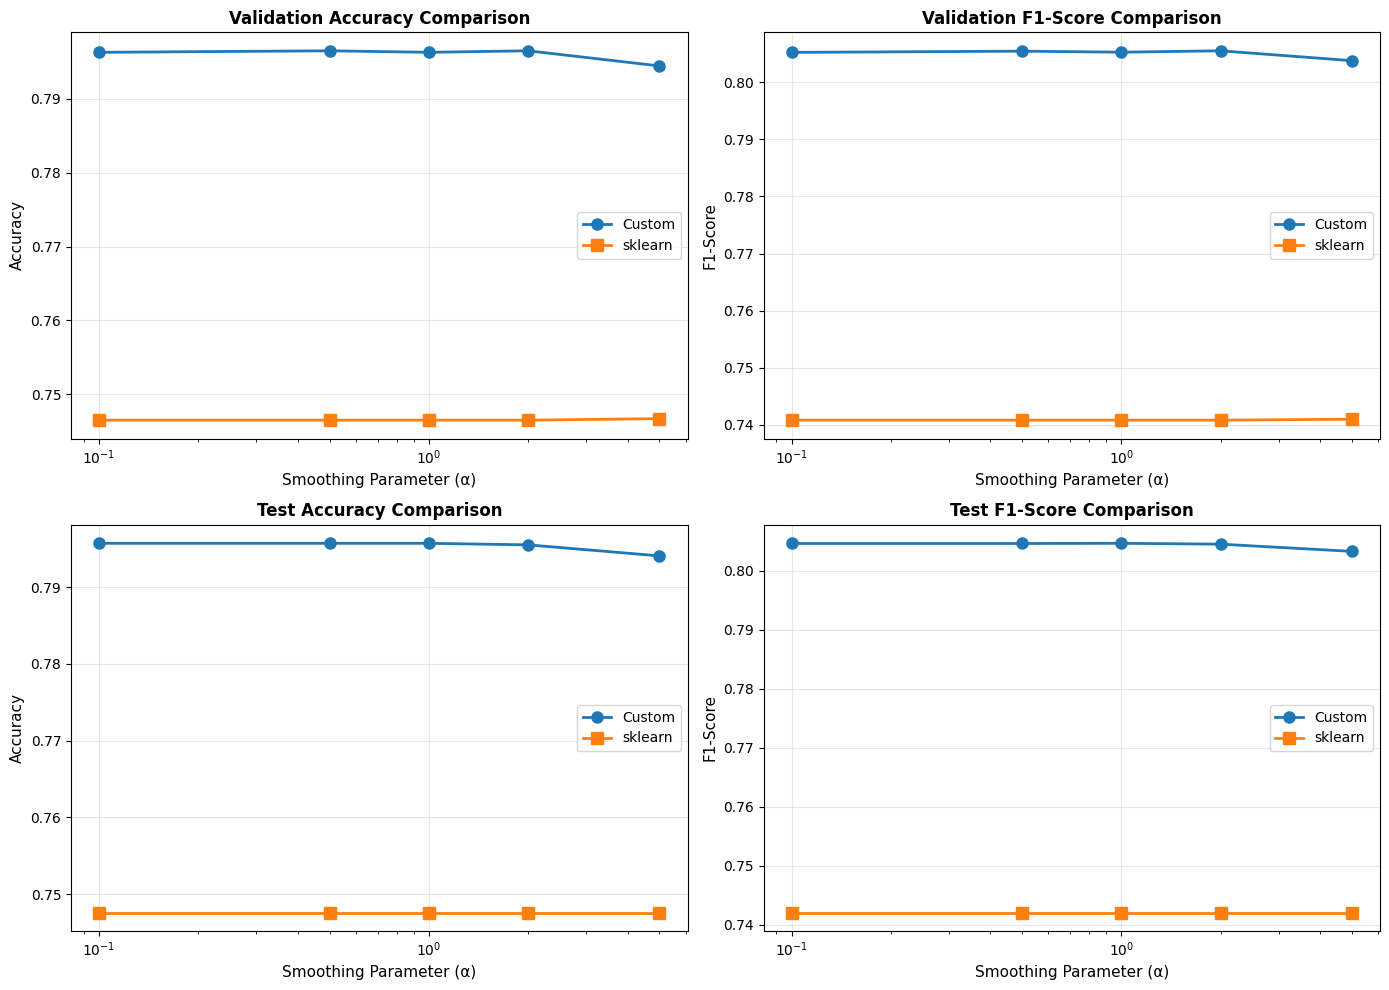


✓ sklearn comparison plot saved!


In [10]:
print("=== Comparison with sklearn's MultinomialNB ===\n")

# Test different alpha values with sklearn
sklearn_results = []

for alpha in alpha_values:
    # sklearn's MultinomialNB
    nb_sklearn = MultinomialNB(alpha=alpha)
    nb_sklearn.fit(X_train, y_train)
    
    # Predictions
    y_pred_val_sklearn = nb_sklearn.predict(X_val)
    y_pred_test_sklearn = nb_sklearn.predict(X_test)
    
    val_acc_sklearn = accuracy_score(y_val, y_pred_val_sklearn)
    val_f1_sklearn = f1_score(y_val, y_pred_val_sklearn, average='weighted')
    test_acc_sklearn = accuracy_score(y_test, y_pred_test_sklearn)
    test_f1_sklearn = f1_score(y_test, y_pred_test_sklearn, average='weighted')
    
    sklearn_results.append({
        'alpha': alpha,
        'val_acc': val_acc_sklearn,
        'val_f1': val_f1_sklearn,
        'test_acc': test_acc_sklearn,
        'test_f1': test_f1_sklearn
    })

sklearn_results_df = pd.DataFrame(sklearn_results)

# Comparison table
print("=== Performance Comparison (α = 1.0) ===\n")
print("Custom Categorical Naïve Bayes vs sklearn's MultinomialNB")
print("-" * 70)

# Custom implementation results for alpha=1.0
custom_idx = results_df[results_df['alpha'] == 1.0].index[0]
custom_val_acc = results_df.loc[custom_idx, 'val_acc']
custom_val_f1 = results_df.loc[custom_idx, 'val_f1']
custom_test_acc = results_df.loc[custom_idx, 'test_acc']
custom_test_f1 = results_df.loc[custom_idx, 'test_f1']

sklearn_idx = sklearn_results_df[sklearn_results_df['alpha'] == 1.0].index[0]
sklearn_val_acc = sklearn_results_df.loc[sklearn_idx, 'val_acc']
sklearn_val_f1 = sklearn_results_df.loc[sklearn_idx, 'val_f1']
sklearn_test_acc = sklearn_results_df.loc[sklearn_idx, 'test_acc']
sklearn_test_f1 = sklearn_results_df.loc[sklearn_idx, 'test_f1']

comparison_data = {
    'Model': ['Custom Implementation', 'sklearn MultinomialNB'],
    'Val_Acc': [custom_val_acc, sklearn_val_acc],
    'Val_F1': [custom_val_f1, sklearn_val_f1],
    'Test_Acc': [custom_test_acc, sklearn_test_acc],
    'Test_F1': [custom_test_f1, sklearn_test_f1]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n=== Full Alpha Comparison ===")
print("\nCustom Implementation:")
print(results_df.to_string(index=False))
print("\nsklearn MultinomialNB:")
print(sklearn_results_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Validation Accuracy
axes[0, 0].plot(results_df['alpha'], results_df['val_acc'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[0, 0].plot(sklearn_results_df['alpha'], sklearn_results_df['val_acc'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

# Validation F1
axes[0, 1].plot(results_df['alpha'], results_df['val_f1'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[0, 1].plot(sklearn_results_df['alpha'], sklearn_results_df['val_f1'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_title('Validation F1-Score Comparison', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# Test Accuracy
axes[1, 0].plot(results_df['alpha'], results_df['test_acc'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[1, 0].plot(sklearn_results_df['alpha'], sklearn_results_df['test_acc'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# Test F1
axes[1, 1].plot(results_df['alpha'], results_df['test_f1'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[1, 1].plot(sklearn_results_df['alpha'], sklearn_results_df['test_f1'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[1, 1].set_ylabel('F1-Score', fontsize=11)
axes[1, 1].set_title('Test F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.savefig('sklearn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ sklearn comparison plot saved!")
